In [80]:
import numpy as np
import tensorflow as tf
import pandas as pd
import scipy.signal
import soundfile as sp
from IPython.display import HTML
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa
import librosa.display
from utils import Preprocessing
from inaSpeechSegmenter import Segmenter
from inaSpeechSegmenter.export_funcs import seg2csv, seg2textgrid
from sklearn.decomposition import  PCA,TruncatedSVD,FastICA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
import random
import config
import random
import os
from  pathlib  import Path 
print("tensorflow version" ,tf.__version__)
device = tf.config.list_physical_devices()[-1]

tensorflow version 2.6.0


In [81]:
#We are initializing the experiment being analyzed
exp = config.experiment["NAME"]
pp =  Preprocessing(config.data['CONVERT_PATH'])

In [82]:
pp.build_single_ds()

500 files read successfully


/net/store/cv/users/ybrima/miniconda3/envs/CV/lib/python3.9/site-packages/librosa/feature/spectral.py:2041: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


1877  1 second audio samples for Pandy created successfully


In [83]:
with np.load( config.data['file_path_pan'] ,allow_pickle=True) as data:
    X = data['x']
    Z =  data['z']
    X_ = (X - X.mean(axis=0, keepdims=True))/X.std(axis=0,keepdims=True)

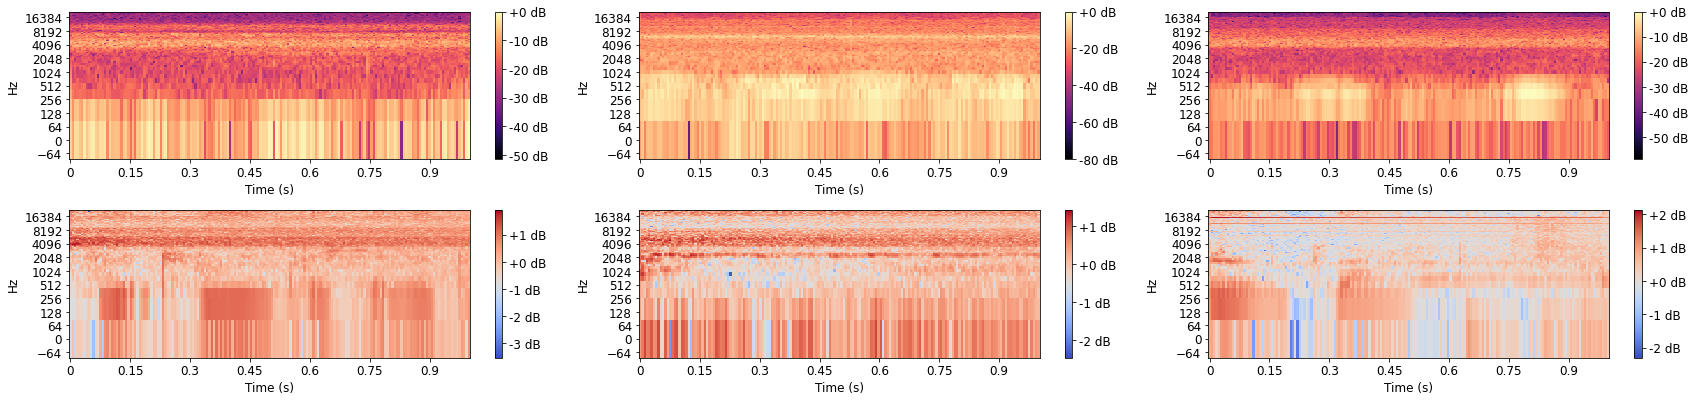

In [84]:
idx =  np.random.randint(0, X.shape[0], 6)
fig = plt.figure(1,figsize=(24,8))
for i,k in enumerate(idx):
    ax = plt.subplot(3,3,i+1)
    if(i+1  <= 3 ):
        img = librosa.display.specshow(X[k],sr=config.audio['SAMPLE_RATE'],y_axis='log', x_axis='s', hop_length=config.audio['HOP_LENGTH']//2) #
    else:
        img = librosa.display.specshow(X_[k],sr=config.audio['SAMPLE_RATE'],y_axis='log', x_axis='s', hop_length=config.audio['HOP_LENGTH']//2) #
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
plt.tight_layout()
plt.show()

In [85]:
features = X_.reshape(X_.shape[0],-1)

In [86]:
model =  PCA(n_components=3, random_state=np.random.seed(42))
X_projection = model.fit_transform(features)

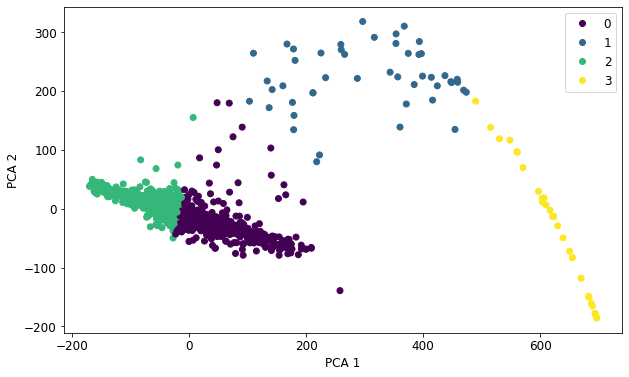

In [87]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X_projection)

#predictions from kmeans
pred = kmeans.predict(X_projection)
frame = pd.DataFrame(X_projection)
frame['cluster'] = pred
frame.columns = ['x', 'y','z', 'cluster']

# #plotting results
fig = plt.figure(1,figsize=(10,6))
scatter = plt.scatter(frame["x"],frame["y"], c=list(pred))
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(handles=scatter.legend_elements()[0], labels=list(np.unique(pred)),bbox_to_anchor=(1.0, 1.0))
plt.savefig(f'./Figures/Pandy_KMeans_{exp}.png', bbox_inches ="tight", dpi=300)
plt.show()

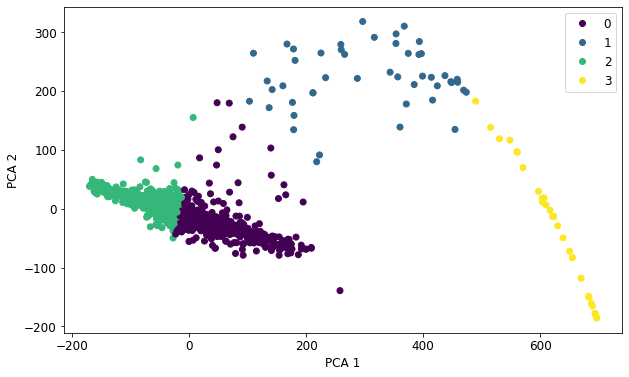

In [88]:
gmm = GaussianMixture(n_components=4)
gmm.fit(X_projection)
#predictions from gmm
labels = gmm.predict(X_projection)
frame = pd.DataFrame(X_projection)
frame['cluster'] = labels
frame.columns = ['x', 'y', 'z','cluster']

fig = plt.figure(1,figsize=(10,6))
scatter = plt.scatter(frame["x"],frame["y"], c=list(pred))
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(handles=scatter.legend_elements()[0], labels=list(np.unique(labels)),bbox_to_anchor=(1.0, 1.0))
plt.savefig(f'./Figures/Pandy_GMM_{exp}.png', bbox_inches ="tight", dpi=300)
plt.show()